**Section 3.7.2**

In [ ]:
!pip install d2l==1.0.0b0

In [ ]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
class Data(d2l.DataModule):
    def __init__(self, num_train, num_val, num_inputs, batch_size):
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = torch.randn(n, num_inputs)
        noise = torch.randn(n, 1) * 0.01
        w, b = torch.ones((num_inputs, 1)) * 0.01, 0.05
        self.y = torch.matmul(self.X, w) + b + noise

    def get_dataloader(self, train):
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader([self.X, self.y], train, i)

In [ ]:
def l2_penalty(w):
    return (w ** 2).sum() / 2

In [ ]:
class WeightDecayScratch(d2l.LinearRegressionScratch):
    def __init__(self, num_inputs, lambd, lr, sigma=0.01):
        super().__init__(num_inputs, lr, sigma)
        self.save_hyperparameters()

    def loss(self, y_hat, y):
        return (super().loss(y_hat, y) +
                self.lambd * l2_penalty(self.w))

In [ ]:
data = Data(num_train=20, num_val=100, num_inputs=200, batch_size=5)
trainer = d2l.Trainer(max_epochs=10)

def train_scratch(lambd):
    model = WeightDecayScratch(num_inputs=200, lambd=lambd, lr=0.01)
    model.board.yscale='log'
    trainer.fit(model, data)
    print('L2 norm of w:', float(l2_penalty(model.w)))

L2 norm of w: 0.008421999402344227


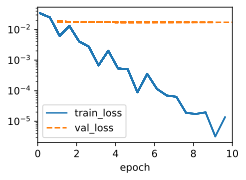

In [ ]:
train_scratch(0)

L2 norm of w: 0.0016658270033076406


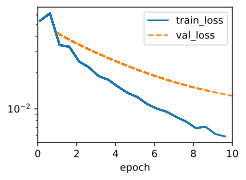

In [ ]:
train_scratch(3)

L2 norm of w: 0.00039796880446374416


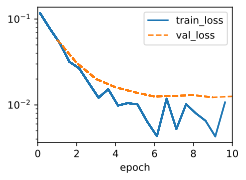

In [ ]:
train_scratch(10)

L2 norm of w: 0.0001137937797466293


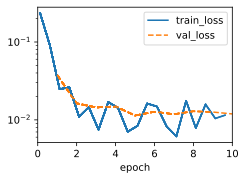

In [ ]:
train_scratch(25)

In [ ]:
class WeightDecay(d2l.LinearRegression):
    def __init__(self, wd, lr):
        super().__init__(lr)
        self.save_hyperparameters()
        self.wd = wd

    def configure_optimizers(self):
        return torch.optim.SGD([
            {'params': self.net.weight, 'weight_decay': self.wd},
            {'params': self.net.bias}], lr=self.lr)

L2 norm of w: 0.013039948418736458


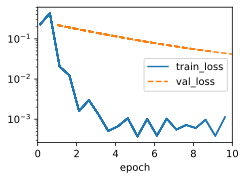

In [ ]:
model = WeightDecay(wd=3, lr=0.01)
model.board.yscale='log'
trainer.fit(model, data)

print('L2 norm of w:', float(l2_penalty(model.get_w_b()[0])))

**Section 3.4**

**1. Define the model**

In [ ]:
#This is the code from 3.2
class Module(nn.Module, d2l.HyperParameters):
    def __init__(self, plot_train_per_epoch=2, plot_valid_per_epoch=1):
        super().__init__()
        self.save_hyperparameters()
        self.board = ProgressBoard()
    def loss(self, y_hat, y):
        raise NotImplementedError

    def forward(self, X):
        assert hasattr(self, 'net'), 'Neural network is defined'
        return self.net(X)

    def plot(self, key, value, train):
        """Plot a point in animation."""
        assert hasattr(self, 'trainer'), 'Trainer is not inited'
        self.board.xlabel = 'epoch'
        if train:
            x = self.trainer.train_batch_idx / \
                self.trainer.num_train_batches
            n = self.trainer.num_train_batches / \
                self.plot_train_per_epoch
        else:
            x = self.trainer.epoch + 1
            n = self.trainer.num_val_batches / \
                self.plot_valid_per_epoch
        self.board.draw(x, value.to(d2l.cpu()).detach().numpy(),
                        ('train_' if train else 'val_') + key,
                        every_n=int(n))
    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=True)
        return l

    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=False)

    def configure_optimizers(self):
        raise NotImplementedError

In [ ]:
#Initialize the weights by drawing random numbers from N(0, 0.01), the magic variance=0.01 always work well in practicce.
#Set the bias=0
class LinearRegressionScratch(d2l.Module):
    def __init__(self, num_inputs, lr, sigma=0.01):#by changing the vaue of sigma to change the variance.
        super().__init__()
        self.save_hyperparameters()
        self.w = torch.normal(0, sigma, (num_inputs, 1), requires_grad=True)# w has d+1 values
        self.b = torch.zeros(1, requires_grad=True)#set b=0

In [ ]:
#deine our model using matrix X times W
@d2l.add_to_class(LinearRegressionScratch)
def forward(self, X):
    """The linear regression model."""
    return torch.matmul(X, self.w) + self.b

**2. Define the Loss function**

In [ ]:
#Use square loss function
#In the implementation, we need to transform the true value y into the predicted value’s shape y_hat by y.reshap(y_hat.shape)?????
@d2l.add_to_class(LinearRegressionScratch)
def loss(self, y_hat, y):
    l = (y_hat - y) ** 2 / 2
    return l.mean()

**3. Define the minibatch stochastic gradient descent optimizer**

In [ ]:
#The subclass of d2l.HyperParameter has the built-in SGD optimizer. We just need to update the parameters. 
class SGD(d2l.HyperParameters):
    def __init__(self, params, lr):
        """Minibatch stochastic gradient descent."""
        self.save_hyperparameters()

    def step(self):
        for param in self.params:
            param -= self.lr * param.grad

    def zero_grad(self):#set all gradients zero, must be run before backpropogation.
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

In [ ]:
#define the configure_optimizers method, which returns an instance of SGD class.
@d2l.add_to_class(LinearRegressionScratch)
def configure_optimizers(self):
    return SGD([self.w, self.b], self.lr)

**4. Implement the training loop**

In each epoch, we iterate through the entire training dataset, passing once through every example.

Note: The number of examples is divisible by the batch_size.

In each iteration, we use a minibatch of training examples and compute its loss, then calculate the gradient with respect to each parameter,.

Lastly, we call the optimization algorithm to update the model parameters.

In [ ]:
@d2l.add_to_class(d2l.Trainer) 
def prepare_batch(self, batch):
    return batch

@d2l.add_to_class(d2l.Trainer)
def fit_epoch(self):
    self.model.train()
    for batch in self.train_dataloader:
        loss = self.model.training_step(self.prepare_batch(batch))
        self.optim.zero_grad()
        with torch.no_grad():
            loss.backward()
            if self.gradient_clip_val > 0:  # To be discussed later
                self.clip_gradients(self.gradient_clip_val, self.model)
            self.optim.step()
        self.train_batch_idx += 1
    if self.val_dataloader is None:
        return
    self.model.eval()
    for batch in self.val_dataloader:
        with torch.no_grad():
            self.model.validation_step(self.prepare_batch(batch))
        self.val_batch_idx += 1

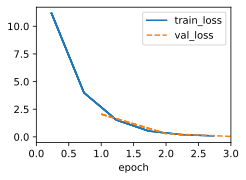

In [ ]:
#Load data to train
# In general both learning rate and number of epochs are hyperparameter.
#3-way-split, one for training, one for hyperparameter selection, one for final evaluation.
model = LinearRegressionScratch(2, lr=0.03)#train the model with learning rate of 0.03 and max_epochs = 3.
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)# the data has w=2, -3.4, b=4.2
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

In [ ]:
print(f'error in estimating w: {data.w - model.w.reshape(data.w.shape)}')
print(f'error in estimating b: {data.b - model.b}')#The parameter learned from the model are close to the true parameters.

error in estimating w: tensor([ 0.1083, -0.1954], grad_fn=<SubBackward0>)
error in estimating b: tensor([0.2041], grad_fn=<RsubBackward1>)


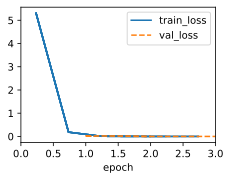

In [ ]:
#Question: change different leraning rate to find how quickly the loss function value drops? Can you reduce the error by increasing the number of epoch of training?
model1 = LinearRegressionScratch(2, lr=0.1)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)# the data has w=2, -3.4, b=4.2
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model1, data)


In [ ]:
print(f'error in estimating w: {data.w - model1.w.reshape(data.w.shape)}')
print(f'error in estimating b: {data.b - model1.b}')

error in estimating w: tensor([-5.1975e-04, -5.0068e-06], grad_fn=<SubBackward0>)
error in estimating b: tensor([0.0003], grad_fn=<RsubBackward1>)


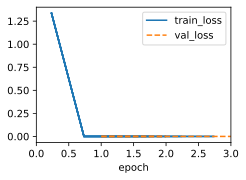

In [ ]:
model2 = LinearRegressionScratch(2, lr=0.5)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model2, data)

In [ ]:
print(f'error in estimating w: {data.w - model2.w.reshape(data.w.shape)}')
print(f'error in estimating b: {data.b - model2.b}')

error in estimating w: tensor([-0.0041,  0.0023], grad_fn=<SubBackward0>)
error in estimating b: tensor([-0.0005], grad_fn=<RsubBackward1>)


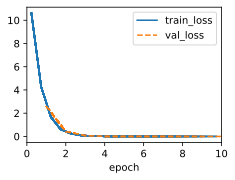

In [ ]:
#Increase the number of epoch
model = LinearRegressionScratch(2, lr=0.03)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

In [ ]:
print(f'error in estimating w: {data.w - model.w.reshape(data.w.shape)}')
print(f'error in estimating b: {data.b - model.b}')

error in estimating w: tensor([ 0.0005, -0.0002], grad_fn=<SubBackward0>)
error in estimating b: tensor([0.0004], grad_fn=<RsubBackward1>)


In [ ]:
data.w.shape #trch.size([2])
data.w# 2, -3.4
model.w #1.89, -3.2046
model.w.shape#torch.size([2, 1])

torch.Size([2, 1])

**Section 5.7**

Predicting House Price

In [ ]:
%matplotlib inline
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [ ]:
def download(url, folder, sha1_hash=None):
    """Download a file to folder and return the local filepath."""

def extract(filename, folder):
    """Extract a zip/tar file into folder."""

In [ ]:
class KaggleHouse(d2l.DataModule):
    def __init__(self, batch_size, train=None, val=None):
        super().__init__()
        self.save_hyperparameters()
        if self.train is None:
            self.raw_train = pd.read_csv(d2l.download(
                d2l.DATA_URL + 'kaggle_house_pred_train.csv', self.root,
                sha1_hash='585e9cc93e70b39160e7921475f9bcd7d31219ce'))
            self.raw_val = pd.read_csv(d2l.download(
                d2l.DATA_URL + 'kaggle_house_pred_test.csv', self.root,
                sha1_hash='fa19780a7b011d9b009e8bff8e99922a8ee2eb90'))

In [ ]:
data = KaggleHouse(batch_size=64)
print(data.raw_train.shape)
print(data.raw_val.shape)

(1460, 81)
(1459, 80)


In [ ]:
print(data.raw_train.iloc[:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [ ]:
@d2l.add_to_class(KaggleHouse)
def preprocess(self):
    # Remove the ID and label columns
    label = 'SalePrice'
    features = pd.concat(
        (self.raw_train.drop(columns=['Id', label]),
         self.raw_val.drop(columns=['Id'])))
    # Standardize numerical columns
    numeric_features = features.dtypes[features.dtypes!='object'].index
    features[numeric_features] = features[numeric_features].apply(
        lambda x: (x - x.mean()) / (x.std()))
    # Replace NAN numerical features by 0
    features[numeric_features] = features[numeric_features].fillna(0)
    # Replace discrete features by one-hot encoding
    features = pd.get_dummies(features, dummy_na=True)
    # Save preprocessed features
    self.train = features[:self.raw_train.shape[0]].copy()
    self.train[label] = self.raw_train[label]
    self.val = features[self.raw_train.shape[0]:].copy()

In [ ]:
data.preprocess()
print(data.train.shape)
print(data.val.shape)

(1460, 332)
(1459, 331)


In [ ]:
data.train.head(5)

In [ ]:
@d2l.add_to_class(KaggleHouse)
def get_dataloader(self, train):
    label = 'SalePrice'
    data = self.train if train else self.val
    if label not in data: return
    get_tensor = lambda x: torch.tensor(x.values, dtype=torch.float32)
    # Logarithm of prices
    tensors = (get_tensor(data.drop(columns=[label])),  # X
               torch.log(get_tensor(data[label])).reshape((-1, 1)))  # Y
    return self.get_tensorloader(tensors, train)

In [ ]:
def k_fold_data(data, k):
    rets = []
    fold_size = data.train.shape[0] // k
    for j in range(k):
        idx = range(j * fold_size, (j+1) * fold_size)
        rets.append(KaggleHouse(data.batch_size, data.train.drop(index=idx),
                                data.train.loc[idx]))
    return rets

In [ ]:
def k_fold(trainer, data, k, lr):
    val_loss, models = [], []
    for i, data_fold in enumerate(k_fold_data(data, k)):
        model = d2l.LinearRegression(lr)
        model.board.yscale='log'
        if i != 0: model.board.display = False
        trainer.fit(model, data_fold)
        val_loss.append(float(model.board.data['val_loss'][-1].y))
        models.append(model)
    print(f'average validation log mse = {sum(val_loss)/len(val_loss)}')
    return models

average validation log mse = 0.18157303750514986


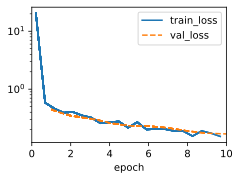

In [ ]:
trainer = d2l.Trainer(max_epochs=10)
models = k_fold(trainer, data, k=5, lr=0.01)

Use different learning rates

In [ ]:
trainer = d2l.Trainer(max_epochs=10)
models = k_fold(trainer, data, k=5, lr=0.05)#leaning rate is 0.05

using a larger learning rate in a gradient descent optimization algorithm can cause the loss function to increase or "expand",
This is because "overshooting" occur when the learning rate is too high and the algorithm takes overly large steps in the direction of the gradient.
When the learning rate is too high, the algorithm may step over the optimal point on the loss curve and end up on the other side, where the loss is actually higher. 
This can result in the loss increasing with each iteration, rather than decreasing towards the minimum. 
sometimes, the algorithm may diverge and oscillate back and forth without converging.

average validation log mse = 0.2603481543064118


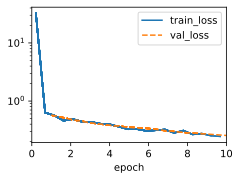

In [ ]:
trainer = d2l.Trainer(max_epochs=10)
models = k_fold(trainer, data, k=5, lr=0.005)#use smaller learning rate increase the logmse

In general, using a smaller learning rate in a gradient descent optimization algorithm is less likely to increase the loss value compared to using a larger learning rate. 
This is because a smaller learning rate typically results in smaller steps towards the minimum of the loss function, which reduces the likelihood of overshooting or diverging.
However, using an excessively small learning rate can slow down the convergence of the optimization algorithm, 
and in some cases, it may even prevent the algorithm from converging to a satisfactory solution. 
This can lead to an increase in the loss value over time or a failure to reduce the loss beyond a certain threshold.

average validation log mse = 0.14748356699943543


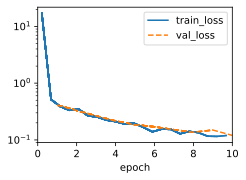

In [ ]:
trainer = d2l.Trainer(max_epochs=10)
models = k_fold(trainer, data, k=5, lr=0.015)#Best results for log mse=0.147 slightly less than 0.182

Use different number of epochs=5, 8, 10, 12, 20, 30

In general, as the number of epochs increases, the model has the opportunity to learn more from the training data, and the loss value typically decreases. This is because the model is refining its parameters through iterative updates based on the training data, with the goal of minimizing the loss function.

However, it is important to note that increasing the number of epochs beyond a certain point may lead to overfitting, where the model becomes too specialized to the training data and performs poorly on new, unseen data.

To strike the right balance between underfitting and overfitting, it is common to monitor the loss value during training and stop the process when the loss has plateaued, or when the performance on a separate validation set has stopped improving. This helps to prevent overfitting while ensuring that the model has learned as much as possible from the training data.

Therefore, my choice is 12!

average validation log mse = 0.2719258761405945


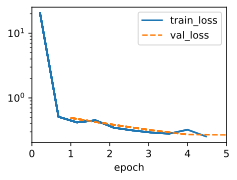

In [ ]:
trainer = d2l.Trainer(max_epochs=5)
models = k_fold(trainer, data, k=5, lr=0.01)#the logmse increase from 0.18 to 0.27

average validation log mse = 0.20243713706731797


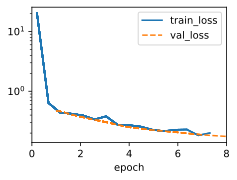

In [ ]:
trainer = d2l.Trainer(max_epochs=8)
models = k_fold(trainer, data, k=5, lr=0.01)#epochs=8 the log mse is 0.202, decrease from epochs=5

average validation log mse = 0.16412238389253617


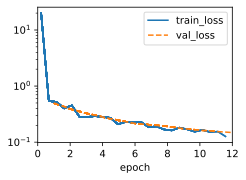

In [ ]:
trainer = d2l.Trainer(max_epochs=12)
models = k_fold(trainer, data, k=5, lr=0.01)#log mse continue to decrese from 0.18 to 0.16 

average validation log mse = 0.14956352293491362


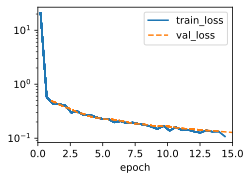

In [ ]:
trainer = d2l.Trainer(max_epochs=15)
models = k_fold(trainer, data, k=5, lr=0.01)# from 0.18 to 0.14

average validation log mse = 0.11986111491918564


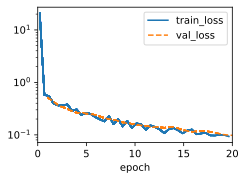

In [ ]:
trainer = d2l.Trainer(max_epochs=20)
models = k_fold(trainer, data, k=5, lr=0.01)# log mse = 0.12

average validation log mse = 0.09389407351613045


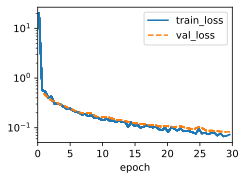

In [ ]:
trainer = d2l.Trainer(max_epochs=30)
models = k_fold(trainer, data, k=5, lr=0.01)#0.093 the val_loss is above the train_loss, this indicates overfitting.

average validation log mse = 0.11490310889979202


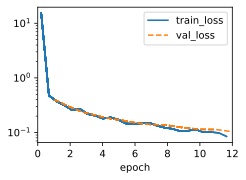

In [ ]:
#K=10, lr=0..015, epochs=12
trainer = d2l.Trainer(max_epochs=12)
models = k_fold(trainer, data, k=10, lr=0.015)#0.114

In [ ]:
preds = [model(torch.tensor(data.val.values, dtype=torch.float32))
         for model in models]
# Taking exponentiation of predictions in the logarithm scale
ensemble_preds = torch.exp(torch.cat(preds, 1)).mean(1)
submission = pd.DataFrame({'Id':data.raw_val.Id,
                           'SalePrice':ensemble_preds.detach().numpy()})
submission.to_csv('submission.csv', index=False)

In [ ]:
ensemble_preds

tensor([ 90049.8828, 463933.5938, 193011.6719,  ..., 240299.0469,
         94027.0156, 199017.2188], grad_fn=<MeanBackward1>)

In [ ]:
submission.to_csv

In [ ]:
# https://www.kaggle.com/c/house-prices-advanced-regression-techniques


**PreProcess data**
Skip this part

In [ ]:
#data.raw_train.shape#(1460, 81)
#data.raw_val.shape#(1459, 80)#has no SalePrice column


(1459, 80)

In [ ]:
#Drop ID column
#data.raw_train.info()
#data.raw_train.drop('Id', axis = 1, inplace = True )
#data.raw_val.drop('Id', axis = 1, inplace = True )


In [ ]:
#print(data.raw_train.shape)
#print(data.raw_val.shape)

(1460, 80)
(1459, 79)


In [ ]:
#check the missing values
#missing_values1 = data.raw_train.isnull().sum()#missing values "LotFrontage" "GarageYrBlt" "MasVnrArea"
#missing_values2 = data.raw_val.isnull().sum()#"LotFrontage" "GarageYrBlt""BsmtHalfBath" "BsmtFullBath" "TotalBamtSF" "GarageCars" "MasVnrArea" "MSZoning", "ScaleType"...
#data.raw_train.select_dtypes(exclude = 'object').isna().mean().sort_values(ascending = False)
#data.raw_val.select_dtypes(exclude = 'object').isna().mean().sort_values(ascending = False)

In [ ]:
#Fill the missing values with 0
#data.raw_train.select_dtypes(exclude = 'object').fillna(0)
#data.raw_val.select_dtypes(exclude = 'object').fillna(0)
#data.raw_train.isnull().sum()
#data.raw_val.isnull().sum()

In [ ]:
#trainx = data.raw_train.iloc[:, :-1]
#trainy = data.raw_train.iloc[:, -1]
#print(trainx.shape)#(1460, 79)
#print(trainy.shape)#(1460, )
#test = data.raw_val
#print(test.shape)

In [ ]:
#create dummy variables
#from sklearn.preprocessing import LabelEncoder  
#train_features_categorical = trainx.select_dtypes(include='object')
#test_features_categorical = test.select_dtypes(include='object')


#le = LabelEncoder()

#for col in train_features_categorical:
#    trainx.loc[:, col] = le.fit_transform(trainx.loc[:, col])
    
    
#for col in test_features_categorical:
#    test.loc[:, col] = le.fit_transform(test.loc[:, col])


In [ ]:
#trainx.head(5)
#trainx.shape
#test.head(5)
#test.shape

(1459, 79)

In [ ]:
# Normalize numerical data
#mean = trainx.mean(axis=0)
#std = trainx.std(axis=0)

#trainx -= mean
#trainx /= std

#test -=mean
#test /= std

In [ ]:
#Fill the missing values with 0
#data.raw_train.select_dtypes(exclude = 'object').fillna(0)
#data.raw_val.select_dtypes(exclude = 'object').fillna(0)

In [ ]:
#trainx.head(10)
#test.head(5)
#trainx.shape
#test.shape

(1459, 79)

**Neural Network Model**

In [ ]:
#Build model
from keras import layers
from keras import models
from keras import regularizers
import tensorflow as tf
from keras.layers import Dense, Dropout

In [ ]:
trainx = data.train.iloc[:, :-1]
trainy = data.train.iloc[:, -1]
print(trainx.shape)#(1460, 79)
print(trainy.shape)#(1460, )
test = data.val
print(test.shape)

(1460, 331)
(1460,)
(1459, 331)


In [ ]:

model = models.Sequential()
model.add(layers.Dense(392, activation='relu', input_shape=(trainx.shape[1],)))
model.add(Dropout(0.2))
model.add(layers.Dense(40, activation='relu'))
model.add(Dropout(0.2))
model.add(layers.Dense(104, activation='relu'))
model.add(layers.Dense(72, activation='relu'))
model.add(layers.Dense(168, activation='relu'))   
model.add(layers.Dense(232, activation='relu'))
model.add(layers.Dense(328, activation='relu'))
model.add(layers.Dense(456, activation='relu'))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(488, activation='relu'))
model.add(layers.Dense(424, activation='relu'))
model.add(Dropout(0.2))
model.add(layers.Dense(456, activation='relu'))
model.add(Dropout(0.2))
model.add(layers.Dense(1))
    
op = tf.keras.optimizers.Adam(learning_rate=0.001)#optimizer is Adam
    
    

In [ ]:
#Compile model
model.compile(optimizer='adam', loss='mae', metrics=['mae'])


In [ ]:
model.summary()

In [ ]:
#Early stopping
#model = build_model()
# from keras.callbacks import EarlyStopping
# es = EarlyStopping(monitor='val_rmse', verbose=1, patience=10)


In [ ]:
# train the model
history = model.fit(trainx, trainy, epochs=20, batch_size = 10, validation_split=0.20)#epoch=150 batch_size=16 verbose=0


Epoch 1/20
117/117 [==============================] - 6s 23ms/step - loss: 66616.3672 - mae: 66616.3672 - val_loss: 31836.4316 - val_mae: 31836.4316
Epoch 2/20
117/117 [==============================] - 2s 18ms/step - loss: 27225.3438 - mae: 27225.3438 - val_loss: 38586.9727 - val_mae: 38586.9727
Epoch 3/20
117/117 [==============================] - 2s 16ms/step - loss: 24630.7383 - mae: 24630.7383 - val_loss: 35273.6602 - val_mae: 35273.6602
Epoch 4/20
117/117 [==============================] - 2s 15ms/step - loss: 22433.2051 - mae: 22433.2051 - val_loss: 22019.4688 - val_mae: 22019.4688
Epoch 5/20
117/117 [==============================] - 2s 15ms/step - loss: 25122.6074 - mae: 25122.6074 - val_loss: 54353.6094 - val_mae: 54353.6094
Epoch 6/20
117/117 [==============================] - 2s 17ms/step - loss: 22054.3926 - mae: 22054.3926 - val_loss: 51803.4727 - val_mae: 51803.4727
Epoch 7/20
117/117 [==============================] - 3s 26ms/step - loss: 22920.9062 - mae: 22920.9062 - 

In [ ]:
#prediction
preds = model.predict(test)
#preds = preds.reshape(1459)
preds.shape

46/46 [==============================] - 1s 12ms/step


(1459, 1)

In [ ]:
model.evaluate(trainx, trainy)

46/46 [==============================] - 0s 7ms/step - loss: 45088.7461 - mae: 45088.7461


[45088.74609375, 45088.74609375]